In [1]:
import pandas as pd
import numpy as np
import os
import json 
import sys
from typing import Dict, Tuple, Any, Optional, List
sys.path.append('..')
import time
from src.utils import load_data

c:\Users\1\anaconda3\envs\rag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sys.path.append(r'C:\Users\1\Documents\GitHub\rageval')
from rageval.models import OpenAILLM

In [16]:
# dataset with human annotations
df_asqa = load_data('../data/asqa/asqa_with_human_343.json')
df_wikieval = load_data('../data/wikieval/all.json')
df_antique = load_data('../data/antique/all.json')

In [5]:
df = load_data('../data/enhance/wikieval.json')

In [6]:
df.columns

Index(['id', 'answer', 'context', 'question', 'model', 'gt_answer', 'dataset',
       'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'Human Accuracy',
       'Human Informativeness', 'Human', 'Rouge L', 'BERT Score',
       'GPT-4o Fine-grained', 'answer_length', 'full_1_gpt-4o',
       'full1_ref_gemini-2.0-flash-exp_acc',
       'full1_ref_gemini-2.0-flash-exp_inf', 'full1_ref_gemini-2.0-flash-exp'],
      dtype='object')

In [68]:
SHORT_INSTRUCTION = """Provide a brief, objective explanation, then rate the response from 1 to 10 using the format: Rating: [[5]].
"""

TASK_INSTRUCTION = """Score the following llm output of a question answering task with respect to following aspects with 1 to 5 stars."""
DATASET_INSTRUCTION = """The dataset is a Factoid Question-Answering dataset, specifically designed for evaluating factual precision and detailed comparative reasoning in AI-generated answers."""
OUTPUT_INSTRUCTION = """Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please provide your evaluation by strictly following the JSON format such as: [[SCORE]] {"accuracy": 2, "informativeness": 3}."""
ACC_INSTRUCTION = """Accuracy: determine the accuracy of the answers, verifying the correctness and reliability of the provided information.
1 star means Incorrect information 
2 stars means Partially correct information 
3 stars means half correct information
4 stars means Mostly correct information 
5 stars means Perfectly correct information"""
INF_INSTRUCTION = """Informativeness: examines whether the answers provide sufficient and meaningful information that useful to the user and relevant to the question.
1 star means No information or irrelevant information
2 star means Very little information
3 stars means Some information
4 stars means Enough information
5 stars means Highly informative"""
ACC_SHORT = """Accuracy: determine the accuracy of the answers, verifying the correctness and reliability of the provided information."""
INF_SHORT = """Informativeness: examines whether the answers provide sufficient and meaningful information that useful to the user and relevant to the question."""


QA = """[Question]
{question}

[The Start of Assistant’s Answer]
{answer}
[The End of Assistant’s Answer]"""

QA_REF = """[Question]
{question}

[The Start of Reference]
{answer_ref}
[The End of Reference]

[The Start of Assistant’s Answer]
{answer}
[The End of Assistant’s Answer]"""

P1 = TASK_INSTRUCTION + DATASET_INSTRUCTION + OUTPUT_INSTRUCTION + '\n'+ACC_INSTRUCTION + '\n' + INF_INSTRUCTION
P2 = TASK_INSTRUCTION + DATASET_INSTRUCTION + OUTPUT_INSTRUCTION
P3 = TASK_INSTRUCTION + DATASET_INSTRUCTION + '\n'+ACC_INSTRUCTION + '\n' + INF_INSTRUCTION + '\n' + OUTPUT_INSTRUCTION
P4 = OUTPUT_INSTRUCTION + TASK_INSTRUCTION + DATASET_INSTRUCTION + '\n'+ACC_INSTRUCTION + '\n' + INF_INSTRUCTION
P5 = TASK_INSTRUCTION + OUTPUT_INSTRUCTION + '\n'+ACC_INSTRUCTION + '\n' + INF_INSTRUCTION
P6 = DATASET_INSTRUCTION + OUTPUT_INSTRUCTION + '\n'+ACC_INSTRUCTION + '\n' + INF_INSTRUCTION
P7 = OUTPUT_INSTRUCTION + '\n'+ACC_INSTRUCTION + '\n' + INF_INSTRUCTION+ '\n'  + TASK_INSTRUCTION + DATASET_INSTRUCTION
P8 = DATASET_INSTRUCTION + TASK_INSTRUCTION + '\n'+ACC_SHORT + '\n' + INF_SHORT+ '\n' + OUTPUT_INSTRUCTION
P9 = DATASET_INSTRUCTION + TASK_INSTRUCTION + '\n'+ACC_INSTRUCTION + '\n' + INF_INSTRUCTION+ '\n' + OUTPUT_INSTRUCTION

In [69]:
def gen_prompt(question, answer, ref=None, system_instruction='', user_instruction=QA):
    if ref is not None:
        return [
            {"role": "system", "content": system_instruction.strip()},
            {"role": "user", "content": user_instruction.format(question=question, answer=answer, answer_ref=ref)}
        ]
    else:
        return [
            {"role": "system", "content": system_instruction.strip()},
            {"role": "user", "content": user_instruction.format(question=question, answer=answer)}
        ]
prompts = [gen_prompt(df['question'][i], df['answer'][i], df['gt_answer'][i], system_instruction=P9, user_instruction=QA_REF) for i in range(len(df))]

In [9]:
from src.models import results_to_dict, get_score_and_re_eval, evaluate

def get_score_and_re_eval(llm_evaluator, results, prompts, texts, use_json=False, max_retries=3):
    def re_eval(prompts):
        r, t = evaluate(llm_evaluator, prompts, cache_path=None, max_workers=16)
        return r, t

    def get_score(texts):
        scores = []
        errors = []
        if not use_json:
            for i, d in enumerate(texts):
                d = d.split("[[")[-1].strip()
                d = d.split("]]")[0].strip()
                try:
                    scores.append(int(d))
                except Exception as e:
                    print(i, e)
                    errors.append(i)
                    scores.append(0)
        else:
            for i, d in enumerate(texts):
                try:
                    d = d.split('[[SCORE]]')[-1].strip()
                    d = json.loads(d)
                    scores.append(d)
                except Exception as e:
                    print(i, e)
                    errors.append(i)
                    scores.append(0)
        return np.array(scores), np.array(errors)

    scores, errors = get_score(texts)
    
    results = np.array(results)
    texts = np.array(texts)
    prompts = np.array(prompts)
    
    retry = 0
    while(len(errors) > 0 and retry < max_retries):
        re_results, re_texts = re_eval(prompts[errors].tolist())
        re_scores, re_errors = get_score(re_texts)
        scores[errors] = re_scores
        results[errors] = re_results
        texts[errors] = re_texts
        errors = re_errors
        retry += 1

    # with open(f"results/{name_suffix}.json", "a+") as f:
    #     f.write(json.dumps([results_to_dict(r) for r in results]))
    return scores, texts, results


In [70]:
models = ['gpt-4o', 'claude-3-5-sonnet-20241022', 'gemini-2.0-flash-exp']
model = 'gpt-4o'

import time
p=9
# prompts = short_prompts
for model in models:
    if model != 'gpt-4o':
        continue
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    llm_evaluator = OpenAILLM(model=model, 
                              _api_key_env_var="API_KEY",
                              base_url=os.getenv("BASE_URL"),)

    results, texts = evaluate(llm_evaluator, prompts, cache_path=None, max_workers=16)
    scores, texts, results = get_score_and_re_eval(llm_evaluator, results, prompts, texts, use_json=True, max_retries=2)
    scores = np.array([[a['accuracy'],a['informativeness']] for a in scores])
    
    with open(f"../data/run/wikieval_{model}_{timestamp}.json", "a+") as f:
         f.write(json.dumps([results_to_dict(r) for r in results]))
    
    # if prompts == short_prompts:
    df[f'p{p}_ref_{model}_acc'] = scores[:,0]
    df[f'p{p}_ref_{model}_inf'] = scores[:,1]
    df[f'p{p}_ref_{model}'] = scores.sum(axis=1)

Generating: 100%|██████████| 350/350 [01:33<00:00,  3.74it/s]


92 Expecting value: line 1 column 1 (char 0)
208 Expecting value: line 1 column 1 (char 0)
300 Expecting value: line 1 column 1 (char 0)


Generating: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


In [71]:
df.to_json(f'../data/enhance/wikieval.json', orient='records', lines=True)

In [87]:
df.columns

Index(['id', 'answer', 'context', 'question', 'model', 'gt_answer', 'dataset',
       'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'Human Accuracy',
       'Human Informativeness', 'Human', 'Rouge L', 'BERT Score',
       'GPT-4o Fine-grained', 'answer_length', 'p_1_gpt-4o',
       'p1_ref_gemini-2.0-flash-exp_acc', 'p1_ref_gemini-2.0-flash-exp_inf',
       'p1_ref_gemini-2.0-flash-exp', 'p2_ref_gpt-4o_acc', 'p2_ref_gpt-4o_inf',
       'p2_ref_gpt-4o', 'p1_ref_gpt-4o_acc', 'p1_ref_gpt-4o_inf',
       'p1_ref_gpt-4o', 'p3_ref_gpt-4o_acc', 'p3_ref_gpt-4o_inf',
       'p3_ref_gpt-4o', 'p4_ref_gpt-4o_acc', 'p4_ref_gpt-4o_inf',
       'p4_ref_gpt-4o', 'p5_ref_gpt-4o_acc', 'p5_ref_gpt-4o_inf',
       'p5_ref_gpt-4o', 'p6_ref_gpt-4o_acc', 'p6_ref_gpt-4o_inf',
       'p6_ref_gpt-4o', 'p7_ref_gpt-4o_acc', 'p7_ref_gpt-4o_inf',
       'p7_ref_gpt-4o', 'p8_ref_gpt-4o_acc', 'p8_ref_gpt-4o_inf',
       'p8_ref_gpt-4o', 'p9_ref_gpt-4o_acc', 'p9_ref_gpt-4o_inf',
       'p9_ref_gpt-4o', 'average_score'],
    

In [132]:
df_kendall = df.groupby('model')[['Human', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('kendall')[['Human']].reset_index().pivot(index='model', columns='level_1', values='Human')[['GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']]

In [143]:
' & '.join([f'{{P{i}}}' for i in range(1,10)])

'{P1} & {P2} & {P3} & {P4} & {P5} & {P6} & {P7} & {P8} & {P9}'

In [133]:
df_kendall

level_1,GPT-4o,Claude-3.5,Gemini-2.0,p1_ref_gpt-4o,p2_ref_gpt-4o,p3_ref_gpt-4o,p4_ref_gpt-4o,p5_ref_gpt-4o,p6_ref_gpt-4o,p7_ref_gpt-4o,p8_ref_gpt-4o,p9_ref_gpt-4o
model,,,,,,,,,,,,
glm4-9b,0.347633,-0.013889,0.320449,0.433268,0.173149,0.382453,0.446342,0.386761,0.388613,0.370174,0.323802,0.422527
gpt-3.5-turbo,0.364742,0.344546,0.299940,0.529161,0.370887,0.641140,0.590102,0.448302,0.515747,0.488293,0.497160,0.563161
llama2-13b,0.516609,0.281606,0.565905,0.681963,0.621847,0.633929,0.600083,0.629797,0.637665,0.637889,0.640677,0.602820
llama2-7b,0.527721,0.416062,0.478938,0.588544,0.556268,0.605561,0.629873,0.571974,0.584629,0.528236,0.587895,0.585584
llama3-8b,0.376630,0.359630,0.194153,0.565894,0.559058,0.453501,0.593916,0.529960,0.412936,0.548832,0.535612,0.533337
mistral-7b,0.399664,0.085460,0.089096,0.335262,0.299075,0.331836,0.237773,0.226648,0.240902,0.332301,0.233912,0.257778
solar-10.7b,0.354548,0.272995,0.440114,0.477493,0.504641,0.571792,0.502481,0.453427,0.401053,0.553951,0.500659,0.595525


In [160]:
avg = df[['Human', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('kendall')['Human'].values[1:]
avg_diff = avg-avg[0]

In [167]:
# Format the table
for i in range(len(df_kendall_diff)):
    # model names
    model_name = df_kendall_diff.index[i]
    if i %2 == 0:
        line = [f'\\rowcolor{{gray!10}}\\textbf{{{model_name}}}']
    else:
        line = [f'\\textbf{{{model_name}}}' ]
    # asqa scores
    # temp 0.0
    line.append(f"{df_kendall.iloc[i, 0]*100:.2f}")
    # temp 0.3, 0.7, 1.0
    for j in range(1, len(df_kendall_diff.columns)):
        val = df_kendall_diff.iloc[i, j]
        if val > 0:
            line.append(f"\cellcolor{{red!{abs((val /0.4))*60:.2f}}}{{{val*100:.2f}}}")
        elif val < 0 :
            line.append(f"\cellcolor{{blue!{abs(val / 0.4)*60:.2f}}}{{{val*100:.2f}}}")
        elif val == 0:
            line.append(f"{{{val:.2f}}}")
    print(' & '.join(line),'\\\\')
print('\midrule')
line = [f'\\textbf{{Average}}']
line.append(f"{avg[0]*100:.2f}")
for i in range(1, len(avg_diff)):
    val = avg_diff[i]
    if val > 0:
        line.append(f"\cellcolor{{red!{abs((val /0.4))*60:.2f}}}{{{val*100:.2f}}}")
    elif val < 0 :
        line.append(f"\cellcolor{{blue!{abs(val / 0.4)*60:.2f}}}{{{val*100:.2f}}}")
    elif val == 0:
        line.append(f"{{{val:.2f}}}")
print(' & '.join(line),'\\\\')

\rowcolor{gray!10}\textbf{glm4-9b} & 34.76 & \cellcolor{blue!54.23}{-36.15} & \cellcolor{blue!4.08}{-2.72} & \cellcolor{red!12.85}{8.56} & \cellcolor{blue!26.17}{-17.45} & \cellcolor{red!5.22}{3.48} & \cellcolor{red!14.81}{9.87} & \cellcolor{red!5.87}{3.91} & \cellcolor{red!6.15}{4.10} & \cellcolor{red!3.38}{2.25} & \cellcolor{blue!3.57}{-2.38} & \cellcolor{red!11.23}{7.49} \\
\textbf{gpt-3.5-turbo} & 36.47 & \cellcolor{blue!3.03}{-2.02} & \cellcolor{blue!9.72}{-6.48} & \cellcolor{red!24.66}{16.44} & \cellcolor{red!0.92}{0.61} & \cellcolor{red!41.46}{27.64} & \cellcolor{red!33.80}{22.54} & \cellcolor{red!12.53}{8.36} & \cellcolor{red!22.65}{15.10} & \cellcolor{red!18.53}{12.36} & \cellcolor{red!19.86}{13.24} & \cellcolor{red!29.76}{19.84} \\
\rowcolor{gray!10}\textbf{llama2-13b} & 51.66 & \cellcolor{blue!35.25}{-23.50} & \cellcolor{red!7.39}{4.93} & \cellcolor{red!24.80}{16.54} & \cellcolor{red!15.79}{10.52} & \cellcolor{red!17.60}{11.73} & \cellcolor{red!12.52}{8.35} & \cellcolor{red!

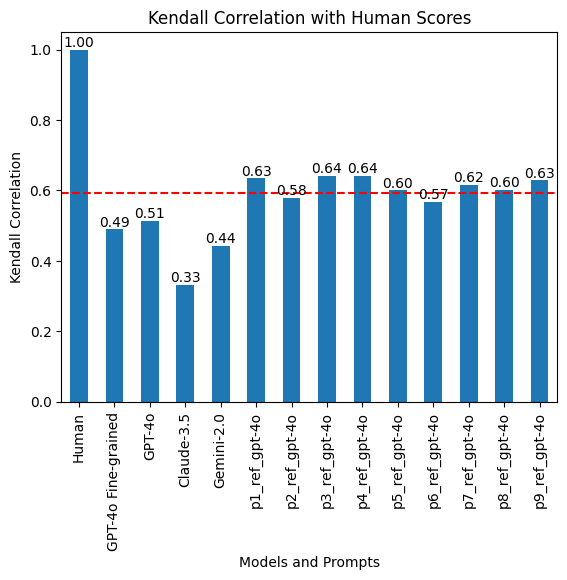

In [86]:
import matplotlib.pyplot as plt

# 绘制条形图
df[['Human', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('spearman')['Human'].plot(kind='bar')
plt.title('Kendall Correlation with Human Scores')
plt.axhline(y=df[['Human', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('spearman')['Human'].mean(), color='r', linestyle='--', label='Average Score')
for i, v in enumerate(df[['Human', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('spearman')['Human']):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
plt.ylabel('Kendall Correlation')
plt.xlabel('Models and Prompts')
plt.show()


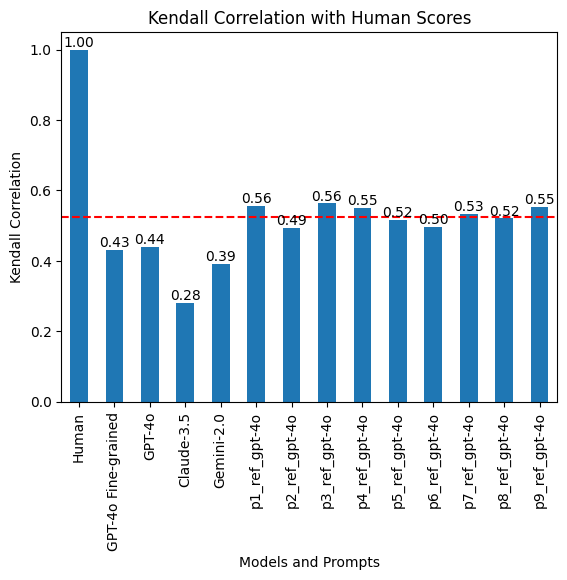

In [85]:
import matplotlib.pyplot as plt

# 绘制条形图
df[['Human', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('kendall')['Human'].plot(kind='bar')
plt.title('Kendall Correlation with Human Scores')
plt.axhline(y=df[['Human', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('kendall')['Human'].mean(), color='r', linestyle='--', label='Average Score')
for i, v in enumerate(df[['Human', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'p1_ref_gpt-4o', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o']].corr('kendall')['Human']):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
plt.ylabel('Kendall Correlation')
plt.xlabel('Models and Prompts')
plt.show()


In [ ]:
df

In [74]:
df[[ 'Human', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0','p1_ref_gpt-4o_acc', 'p1_ref_gpt-4o_inf', 'p1_ref_gpt-4o','p2_ref_gpt-4o_acc', 'p2_ref_gpt-4o_inf', 'p2_ref_gpt-4o', 'p3_ref_gpt-4o_acc', 'p3_ref_gpt-4o_inf', 'p3_ref_gpt-4o',  'p4_ref_gpt-4o_acc', 'p4_ref_gpt-4o_inf', 'p4_ref_gpt-4o', 'p5_ref_gpt-4o_acc', 'p5_ref_gpt-4o_inf', 'p5_ref_gpt-4o', 'p6_ref_gpt-4o_acc', 'p6_ref_gpt-4o_inf', 'p6_ref_gpt-4o', 'p7_ref_gpt-4o_acc', 'p7_ref_gpt-4o_inf', 'p7_ref_gpt-4o', 'p8_ref_gpt-4o_acc', 'p8_ref_gpt-4o_inf', 'p8_ref_gpt-4o', 'p9_ref_gpt-4o_acc', 'p9_ref_gpt-4o_inf', 'p9_ref_gpt-4o']].corr('kendall')['Human']

Human                  1.000000
GPT-4o Fine-grained    0.431107
GPT-4o                 0.438889
Claude-3.5             0.279742
Gemini-2.0             0.390517
p1_ref_gpt-4o_acc      0.450588
p1_ref_gpt-4o_inf      0.556933
p1_ref_gpt-4o          0.555668
p2_ref_gpt-4o_acc      0.468796
p2_ref_gpt-4o_inf      0.426981
p2_ref_gpt-4o          0.493713
p3_ref_gpt-4o_acc      0.434888
p3_ref_gpt-4o_inf      0.579634
p3_ref_gpt-4o          0.563257
p4_ref_gpt-4o_acc      0.464709
p4_ref_gpt-4o_inf      0.553778
p4_ref_gpt-4o          0.550410
p5_ref_gpt-4o_acc      0.446279
p5_ref_gpt-4o_inf      0.514216
p5_ref_gpt-4o          0.515954
p6_ref_gpt-4o_acc      0.387250
p6_ref_gpt-4o_inf      0.524473
p6_ref_gpt-4o          0.496271
p7_ref_gpt-4o_acc      0.436862
p7_ref_gpt-4o_inf      0.524314
p7_ref_gpt-4o          0.533789
p8_ref_gpt-4o_acc      0.427491
p8_ref_gpt-4o_inf      0.515107
p8_ref_gpt-4o          0.521003
p9_ref_gpt-4o_acc      0.473684
p9_ref_gpt-4o_inf      0.551267
p9_ref_g

In [164]:
df.to_json(f'../data/enhance/wikieval.json', orient='records', lines=True)

In [25]:
df[[ 'Human', 'gpt-4o short ref', 'claude-3.5 short ref', 'gemini-2.0 short ref',]].corr('kendall')

,Human,gpt-4o short,claude-3.5 short,gemini-2.0 short
Human,1.000000,0.456888,0.126869,0.371571
gpt-4o short,0.456888,1.000000,0.058805,0.348244
claude-3.5 short,0.126869,0.058805,1.000000,-0.011171
gemini-2.0 short,0.371571,0.348244,-0.011171,1.000000


In [18]:
df[['short_score', 'short_claude-3-5-sonnet-20241022_score', 'short_gemini-2.0-flash-exp_score', 'Human']].corr('spearman')

,short_score,short_claude-3-5-sonnet-20241022_score,short_gemini-2.0-flash-exp_score,Human
short_score,1.000000,0.072585,0.378692,0.518712
short_claude-3-5-sonnet-20241022_score,0.072585,1.000000,-0.014624,0.155643
short_gemini-2.0-flash-exp_score,0.378692,-0.014624,1.000000,0.410101
Human,0.518712,0.155643,0.410101,1.000000


In [21]:
df[['Human', 'Claude-3.5', 'Gemini-2.0', 'GPT-4o', 'GPT-4o Fine-grained']].corr('kendall')

,Human,Claude-3.5,Gemini-2.0,GPT-4o,GPT-4o Fine-grained
Human,1.000000,0.279742,0.390517,0.438889,0.431107
Claude-3.5,0.279742,1.000000,0.201393,0.544142,0.487806
Gemini-2.0,0.390517,0.201393,1.000000,0.414870,0.357246
GPT-4o,0.438889,0.544142,0.414870,1.000000,0.618806
GPT-4o Fine-grained,0.431107,0.487806,0.357246,0.618806,1.000000


In [22]:
df[['Human', 'Claude-3.5', 'Gemini-2.0', 'GPT-4o', 'GPT-4o Fine-grained']].corr('spearman')

,Human,Claude-3.5,Gemini-2.0,GPT-4o,GPT-4o Fine-grained
Human,1.000000,0.331051,0.442342,0.513881,0.489855
Claude-3.5,0.331051,1.000000,0.233424,0.639333,0.566608
Gemini-2.0,0.442342,0.233424,1.000000,0.477487,0.401275
GPT-4o,0.513881,0.639333,0.477487,1.000000,0.706005
GPT-4o Fine-grained,0.489855,0.566608,0.401275,0.706005,1.000000


In [11]:
calculate_correlation(df['GPT-4o Fine-grained'], df['Human'])


48.98549784761374